In [35]:
import os
import numpy as np
import pprint
import glob
import matplotlib.pyplot as plt
from PIL import Image
import skimage.util as util
import torch
import torch.nn as nn
import torch.nn.functional as F
import igraph as ig
from igraph import Graph
import sklearn.metrics as metrics
import warnings
import time
from tqdm import tqdm
import skimage.filters
import sklearn.metrics
import seaborn as sns
import pandas as pd
from skimage import data, segmentation, color
from skimage.segmentation import slic, mark_boundaries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
warnings.filterwarnings("ignore")
%load_ext line_profiler
from time import time

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
if device == "cuda":
    torch.backends.cudnn.deterministic = True
else:
    torch.backends.mps.deterministic = True

import wandb
wandb.login()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


True

In [59]:
def show(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def generate_square(size=(224, 224), fore_back_ratio=0.5, noise=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    square_width = int(np.sqrt(fore_back_ratio * size[0] * size[1]))
    square_position_x = np.random.randint(0, size[0] - square_width)
    square_position_y = np.random.randint(0, size[1] - square_width)
    image = np.ones(size)
    image[square_position_x:square_position_x+square_width, square_position_y:square_position_y+square_width] = 0
    return image

def add_noise(image, amount=0.5, seed=None):
    image = util.random_noise(image, mode='gaussian', seed=seed, clip=False, var=amount)
    image = image / np.max(image)
    return image

def generate_image(size=(224, 224), fore_back_ratio=0.5, noise=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    image = generate_square(size, fore_back_ratio, noise, seed)
    pixelwise_labels = image.copy()
    image = add_noise(image, amount=noise, seed=seed)
    return image, pixelwise_labels

def tile(image, pixelwise_labels=None, method='grid', d=10):
    if method == 'grid':
        if image.shape[0] % d != 0 or image.shape[1] % d != 0:
            raise ValueError('image shape must be divisible by d')
        else:
            tile_width = (image.shape[0] // d)
            tile_height = (image.shape[1] // d)
            image_tensor = torch.tensor(image, dtype=torch.float32)
            if len(image_tensor.shape) < 3:
                image_tensor = image_tensor.unsqueeze(2)
            tiles = image_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
            tiles = tiles.permute(0, 1, 3, 4, 2)
            tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width, tile_height, tiles.shape[4])

            if pixelwise_labels is not None:
                pixelwise_labels_tensor = torch.tensor(pixelwise_labels)
                if len(pixelwise_labels_tensor.shape) < 3:
                    image_tensor = image_tensor.unsqueeze(2)
                pixelwise_labels_tiles = pixelwise_labels_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
                pixelwise_labels_tiles = pixelwise_labels_tiles.reshape(pixelwise_labels_tiles.shape[0] * pixelwise_labels_tiles.shape[1], tile_width * tile_height)
                tilewise_labels = pixelwise_labels_tiles.mean(axis=1).round()
                return tiles, tilewise_labels
            else:
                return tiles
    else:
        raise ValueError('method not implemented')
    

def arbitrary_labels(n, proportion=0.5):
    randoms = torch.rand(n)
    labels = torch.zeros(n)
    labels[randoms > proportion] = 1
    return labels

def generate_tiles(size=(224, 224), fore_back_ratio=0.5, noise=0.5, d=8, seed=None):
    if seed is not None:
        np.random.seed(seed)
    image, pixelwise_labels = generate_image(size, fore_back_ratio, noise, seed)
    tiles, tilewise_labels = tile(image, pixelwise_labels, d=d)
    return tiles, tilewise_labels, arbitrary_labels(tilewise_labels.shape[0], seed=seed)

def visualize_tiles(tiles, tilewise_labels=None, show_labels=True):
    d = int(np.sqrt(tiles.shape[0]))
    fig, axs = plt.subplots(d,d, figsize=(d//2,d//2))
    for i in range(d):
        for j in range(d):
            axs[i, j].imshow(tiles[i * d + j], cmap='gray', vmin=0, vmax=1)
            if show_labels and tilewise_labels is not None:
                axs[i, j].text(2, 2, f'{tilewise_labels[i * d + j]:.2f}', color='white', fontsize=6, bbox=dict(fill=True, facecolor='purple', linewidth=0), verticalalignment='top', horizontalalignment='left')
            axs[i, j].axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


def graph_cut(d, probabilities, lambda_):
    g = Graph.Lattice(dim=[d, d], circular=False)
    g.add_vertices(2)
    weights = np.zeros(g.ecount() + (2*d*d))
    s = d*d
    t = s + 1
    st_edges = np.array([(i, s) for i in range(d*d)] + [(i, t) for i in range(d*d)])
    g.add_edges(st_edges)
    weights[:-2*d*d] = lambda_
    scaled_probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())
    weights[-2*d*d:-1*d*d] = scaled_probabilities
    weights[-1*d*d:] = 1 - scaled_probabilities
    g.es['weight'] = weights

    colors = np.concatenate((np.zeros(d*d), np.array([1,2])))
    g.vs["color"] = ["gray" if c == 0 else ("black" if c == 1 else "white") for c in colors]

    # assignments = np.array(g.maxflow(s, t, "weight").membership[:-2])

    mc = g.st_mincut(s, t, "weight")
    bg = mc.partition[0]
    bg.remove(s)
    assignments = np.zeros(d*d)
    assignments[bg] = 1
    return assignments, g

def visualize_graph(g, d, labels=None):
    if labels is None:
        colors = np.concatenate((np.zeros(d*d), np.array([2,3])))
        g.vs["color"] = ["gray" if c == 0 else ("black" if c == 2 else "white") for c in colors]
    else:
        colors = np.concatenate((labels.astype(int), np.array([1,0])))
        g.vs["color"] = ["black" if c == 0 else "white" for c in colors]

    fig, ax = plt.subplots(figsize=(8,8))
    layout = np.zeros((d*d + 2, 2))
    for i in range(d*d + 2):
        if i < d*d:
            layout[i, 0] = (i % d)
            layout[i, 1] = -1 * (i // d)
        elif i == d*d:
            layout[i, 1] = 2
            layout[i, 0] = (d - 1) / 2
        elif i == d*d + 1:
            layout[i, 1] = -1 * (d + 1)
            layout[i, 0] = (d - 1) / 2

    n_edges = g.ecount()
    n_lattice_edges = n_edges - 2*d*d
            
    ig.plot(g, target=ax, edge_width=g.es["weight"], layout=layout)
    plt.show()

def auto_threshold(probabilities):
    t = skimage.filters.threshold_otsu(probabilities)
    return t

def evaluate(pixelwise_probabilities, pixelwise_labels, allow_inverse=True, plot=True):
    pixelwise_predictions = pixelwise_probabilities
    pixelwise_predictions = pixelwise_predictions.astype(int).reshape(-1)
    pixelwise_labels = pixelwise_labels.astype(int).reshape(-1)
    accuracy = accuracy_score(pixelwise_labels, pixelwise_predictions)
    if allow_inverse and accuracy < 0.5:
        pixelwise_predictions = 1 - pixelwise_predictions
        accuracy = accuracy_score(pixelwise_labels, pixelwise_predictions)
    report = classification_report(pixelwise_labels, pixelwise_predictions, output_dict=True)
    conf_matrix = confusion_matrix(pixelwise_labels, pixelwise_predictions)
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        sns.heatmap(conf_matrix, ax=axs[0], annot=True, fmt="d", cmap=plt.cm.Blues)
        axs[0].set_title('Confusion Matrix')
        sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, ax=axs[1], annot=True)
        axs[1].set_title('Classification Report')
        illustration = pixelwise_labels.reshape(pixelwise_probabilities.shape[0], pixelwise_probabilities.shape[1]) != pixelwise_predictions.reshape(pixelwise_probabilities.shape[0], pixelwise_probabilities.shape[1])
        axs[2].imshow(illustration)
        axs[2].set_title('Incorrect Predictions')
        plt.tight_layout()
        plt.show()
    return accuracy, report, conf_matrix

class TileDS(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

class CNN(nn.Module):
    def __init__(self, image_size=(32,32), n_filters=16, n_channels=1, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_filters, 3, padding=1)
        self.BN1 = nn.BatchNorm2d(n_filters)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(n_filters, n_filters, 3, padding=1)
        self.BN2 = nn.BatchNorm2d(n_filters)
        self.dropout2 = nn.Dropout(dropout)
        self.conv3 = nn.Conv2d(n_filters, 1, 3, padding=1)
        self.BN3 = nn.BatchNorm2d(1)
        self.dropout3 = nn.Dropout(dropout)
        self.output = nn.Linear(image_size[0] * image_size[1], 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.BN3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
class CNN_2(nn.Module):
    def __init__(self, image_size=(32,32), n_filters=16, n_channels=1, dropout=0.2):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_filters, 3, padding=1)
        self.BN1 = nn.BatchNorm2d(n_filters)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(n_filters + n_channels, n_filters, 5, padding=2)
        self.BN2 = nn.BatchNorm2d(n_filters)
        self.dropout2 = nn.Dropout(dropout)
        self.conv3 = nn.Conv2d(n_filters + n_channels, 1, 7, padding=3)
        self.BN3 = nn.BatchNorm2d(1)
        self.dropout3 = nn.Dropout(dropout)
        self.output = nn.Linear(image_size[0] * image_size[1], 1)

    def forward(self, x):
        input_ = x
        x = self.conv1(x)
        x = self.BN1(x)
        x = F.relu(x)
        conv1_output = self.dropout1(x)
        x = torch.cat((conv1_output, input_), 1)
        x = self.conv2(x)
        x = self.BN2(x)
        x = F.relu(x)
        conv2_output = self.dropout2(x)
        x = torch.cat((conv2_output, input_), 1)
        x = self.conv3(x)
        x = self.BN3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x


class GraphicallyGuidedEMSegmentor:
    def __init__(self, d=16, n_filters=16, dropout=0.2, lambda_=0.3, size=(512, 512), lr=0.001, iterations=100, subset_size=0.5, prediction_stride=1, seed=0):
        self.d = d
        self.n_filters = n_filters
        self.dropout = dropout
        self.lambda_ = lambda_
        self.size = size
        self.tile_size = (size[0] // d, size[1] // d)
        self.lr = lr
        self.iterations = iterations
        self.subset_size = subset_size
        self.prediction_stride = prediction_stride
        self.seed = seed
        self.net = None
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []

    def fit(self, image):
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.image = image
        
        if self.seed is not None:
            torch.manual_seed(self.seed)
        X = tile(image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        y_initial = arbitrary_labels(self.d**2).type(torch.float32).to(device).unsqueeze(1)

        self.net = CNN(image_size=self.tile_size, n_filters=self.n_filters, n_channels=X.shape[1], dropout=self.dropout).to(device)
        
        # train CNN
        y_intermediate = y_initial.clone().detach()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        itertimes = []
        graphtimes = []
        for iteration in range(self.iterations):
            start = time()
            # extract subset of data
            shuffled_idx = torch.randperm(X.shape[0])
            X_shuffled = X[shuffled_idx]
            y_intermediate_shuffled = y_intermediate[shuffled_idx]
            X_subset = X_shuffled[:int(self.subset_size * X.shape[0])]
            y_intermediate_subset = y_intermediate_shuffled[:int(self.subset_size * X.shape[0])]

            inputs = X_subset
            labels = y_intermediate_subset
            optimizer.zero_grad()
            outputs = self.net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # update y_intermediate
            probabilities = self.net(X).detach().squeeze(1).cpu().numpy()
            graph_start = time()
            partition, g = graph_cut(self.d, probabilities, self.lambda_)
            graphtimes.append(time() - graph_start)
            y_intermediate = torch.Tensor(partition).type(torch.float32).to(device).unsqueeze(1)

            # save intermediate results
            self.losses.append(loss.item() / X.shape[0])
            self.intermediate_partitions.append(partition)
            self.intermediate_probabilities.append(probabilities)
            self.intermediate_graphs.append(g)
            itertimes.append(time() - start)
        print("Average training time per iteration:", np.array(itertimes).mean())
        print("Average graph cut time:", np.array(graphtimes).mean())

    def predict(self):
        stride = self.prediction_stride
        image = self.image
        image_tensor = torch.tensor(image, dtype=torch.float32)
        all_tiles = image_tensor.unfold(0, self.tile_size[0], stride).unfold(1, self.tile_size[1], stride).reshape(-1, 1, self.tile_size[0], self.tile_size[1]).to(device)

        all_tiles_ds = TileDS(all_tiles)

        # set up dataloaders
        batch_size = 4096
        if device == "cuda":
            batch_size = 16384
        loader = torch.utils.data.DataLoader(all_tiles_ds, batch_size=batch_size, shuffle=False)
        n_batches = len(loader)

        with torch.no_grad():
            all_tiles_predictions = torch.zeros((len(all_tiles_ds))).to(device)
            for batch_i, batch in tqdm(enumerate(loader), total=n_batches):
                batch_predictions = self.net(batch)
                all_tiles_predictions[batch_i*loader.batch_size:(batch_i+1)*loader.batch_size] = batch_predictions.squeeze(1)

        predictions = all_tiles_predictions.reshape(((self.size[0] - self.tile_size[0]) // stride) + 1, ((self.size[1] - self.tile_size[1]) // stride) + 1)
        pixelwise_probabilities = torch.nn.functional.interpolate(predictions.unsqueeze(0).unsqueeze(0), size=image.shape, mode='bilinear', align_corners=True)
        pixelwise_probabilities -= pixelwise_probabilities.min()
        pixelwise_probabilities /= pixelwise_probabilities.max()
        pixelwise_probabilities *= 255
        pixelwise_probabilities = pixelwise_probabilities.squeeze(0).squeeze(0).cpu().numpy().astype(np.uint8)
        grayscale = False
        if 3 not in image.shape:
            grayscale = True
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        segments = slic(image, n_segments=100, sigma=3)
        segmentation = color.label2rgb(segments, pixelwise_probabilities, kind='avg', bg_label=0)
        segmentation = segmentation > auto_threshold(segmentation)
        if grayscale:
            segmentation = segmentation[:, :, 0]
        return segmentation
    
def generate_training_report(segmentor):
    fig, axs = plt.subplots(1, 4, figsize=(10, 3))
    axs[0].set_title('Image')
    axs[0].axis('off')
    axs[0].imshow(segmentor.image, cmap='gray')
    axs[1].set_title('Network Loss')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].plot(segmentor.losses)
    axs[2].set_title('Final Network Probabilities')
    axs[2].axis('off')
    axs[2].imshow(segmentor.intermediate_probabilities[-1].reshape(segmentor.d, segmentor.d))
    axs[3].set_title('Final Graph Partition')
    axs[3].axis('off')
    axs[3].imshow(segmentor.intermediate_partitions[-1].reshape(segmentor.d, segmentor.d))
    plt.tight_layout()
    plt.show()

def generate_complex_image(size=(224, 224), noise=0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    mask_paths = glob.glob("blobs/*.png")
    texture_paths = glob.glob("textures/*.tiff")
    mask_path = np.random.choice(mask_paths)
    texture1_path, texture2_path = np.random.choice(texture_paths, size=2)
    mask = np.array(Image.open(mask_path).resize(size, resample=Image.NEAREST))
    texture1 = np.array(Image.open(texture1_path).resize(size, resample=Image.NEAREST))
    texture2 = np.array(Image.open(texture2_path).resize(size, resample=Image.NEAREST))
    image = np.where(mask > 0, texture1, texture2) / 255
    labels = mask > 0
    if noise > 0:
        image = add_noise(image, amount=noise, seed=seed)
    return image, labels

In [74]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'Avg. F1 Score',
        'goal': 'maximize'
    },
    'parameters': {
        'd': {
            'values': [8, 16, 32, 64]
        },
        'n_filters': {
            'values': [16, 32, 64, 128]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3, 0.4, 0.5]
        },
        'lambda_': {
            'values': [0.1, 0.2, 0.3, 0.4, 0.5]
        },
        'lr': {
            'values': [0.0001, 0.0005, 0.001, 0.005, 0.01]
        },
        'iterations': {
            'values': [100, 200, 300, 400, 500]
        },
        'subset_size': {
            'values': [0.1, 0.3, 0.5, 0.7]
        },
        'prediction_stride': {
            'value': 4
        },
        'image_size': {
            'value': (512,512)
        },
        'noise': {
            'value': 0
        },
        'seed': {
            'value': 0
        }
    }
}

representative_test_images = [
    "gt_2.png_1.1.01.tiff_1.1.04.tiff", # easy
    "gt_2.png_1.1.01.tiff_1.1.12.tiff", # easy
    "gt_2.png_1.1.02.tiff_1.1.05.tiff", # medium
    "gt_2.png_1.1.02.tiff_1.1.13.tiff", # medium
    "gt_2.png_1.1.03.tiff_1.1.02.tiff", # hard
    "gt_2.png_1.1.03.tiff_1.1.04.tiff"  # hard
]

def run_experiment(config=None):
    with wandb.init(config=config):
        config = wandb.config
        f1_scores = np.zeros(len(representative_test_images))
        for image_index, test_image_name in enumerate(representative_test_images):
            image = np.array(Image.open(f'test_images/{test_image_name}_image.png').resize(config.image_size, resample=Image.NEAREST)) / 255
            pixelwise_labels = np.array(Image.open(f'test_images/{test_image_name}_labels.png').resize(config.image_size, resample=Image.NEAREST)) > 0
            image = np.array(Image.fromarray(image[:-3, :]).resize(config.image_size, resample=Image.NEAREST))
            pixelwise_labels = np.array(Image.fromarray(pixelwise_labels[:-3, :]).resize(config.image_size, resample=Image.NEAREST))
            segmentor = GraphicallyGuidedEMSegmentor(d=config.d, n_filters=config.n_filters, dropout=config.dropout, lambda_=config.lambda_, size=config.image_size, lr=config.lr, iterations=config.iterations, subset_size=config.subset_size, prediction_stride=config.prediction_stride, seed=config.seed)
            segmentor.fit(image)
            generate_training_report(segmentor)
            segmentation = segmentor.predict()
            accuracy, report, conf_matrix = evaluate(pixelwise_labels, segmentation, plot=True)
            f1_scores[image_index] = report["weighted avg"]["f1-score"]
        wandb.log({"Avg. F1 Score": f1_scores.mean()})

Average training time per iteration: 0.04683586120605469
Average graph cut time: 0.0007898664474487305


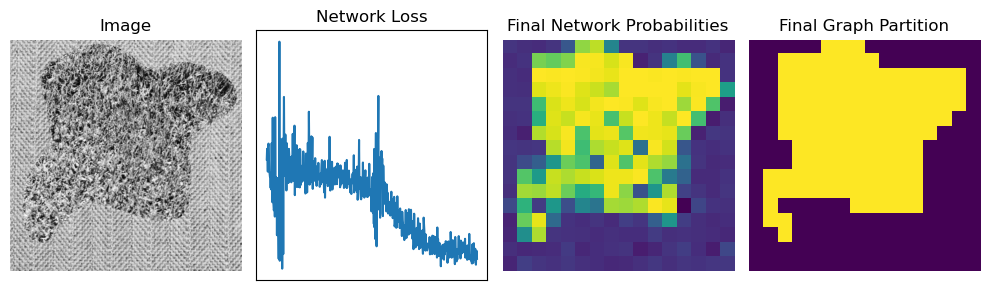

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


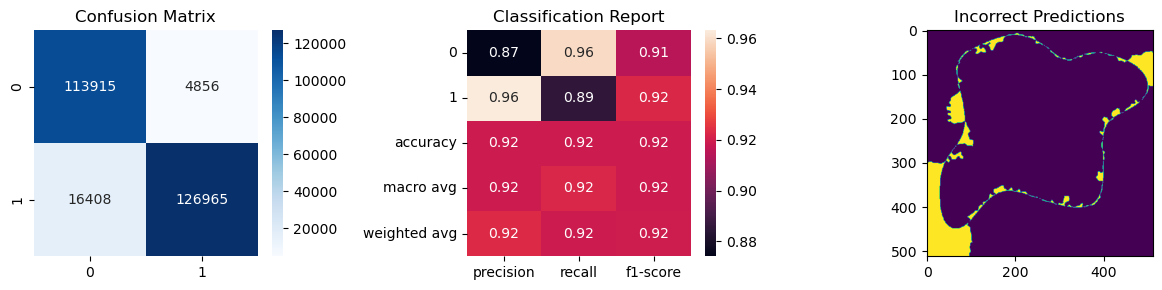

Average training time per iteration: 0.04693138321240743
Average graph cut time: 0.0008209820588429769


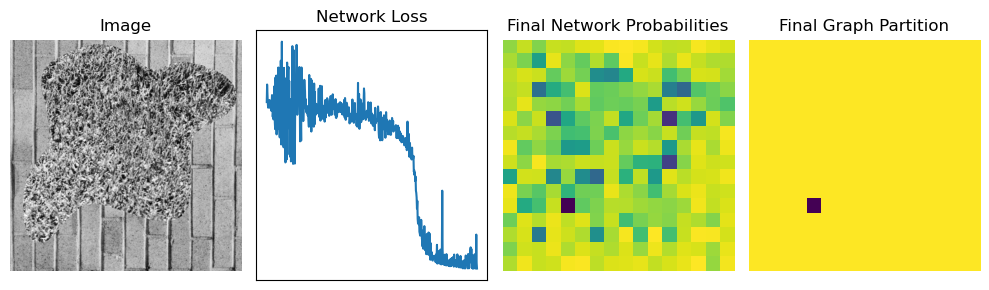

100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


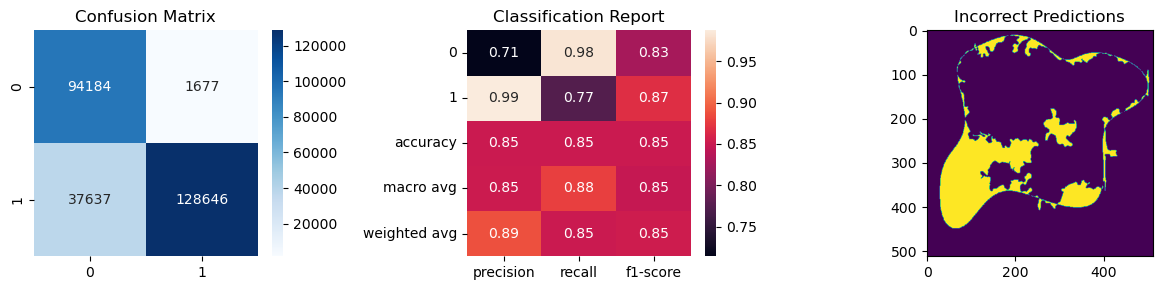

Average training time per iteration: 0.046774616241455076
Average graph cut time: 0.0007912532488505046


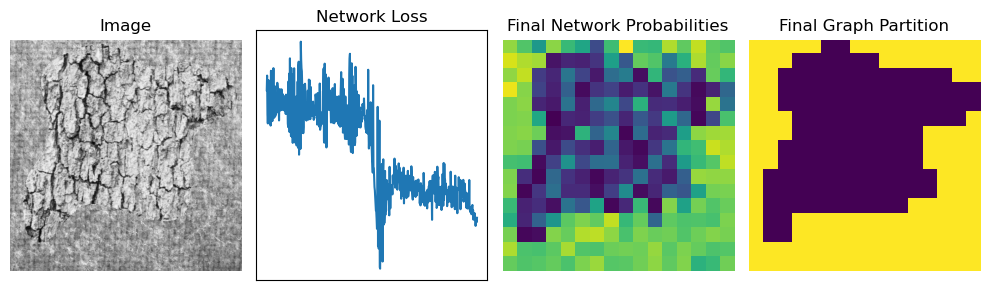

100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


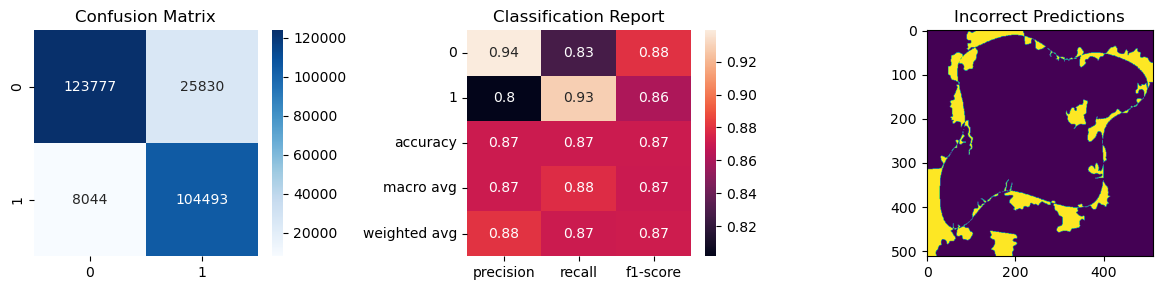

Average training time per iteration: 0.0468575656414032
Average graph cut time: 0.0007932567596435547


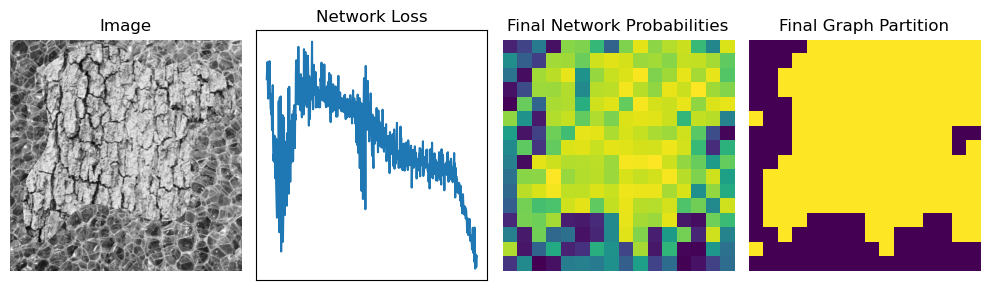

100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


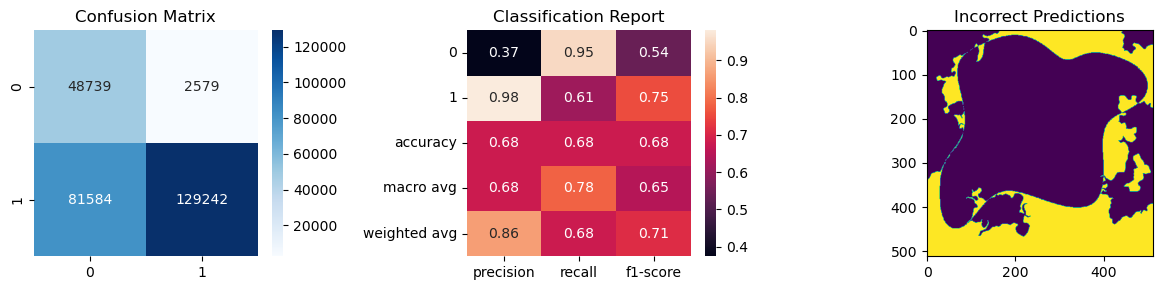

Average training time per iteration: 0.04705300728480021
Average graph cut time: 0.0008012084166208903


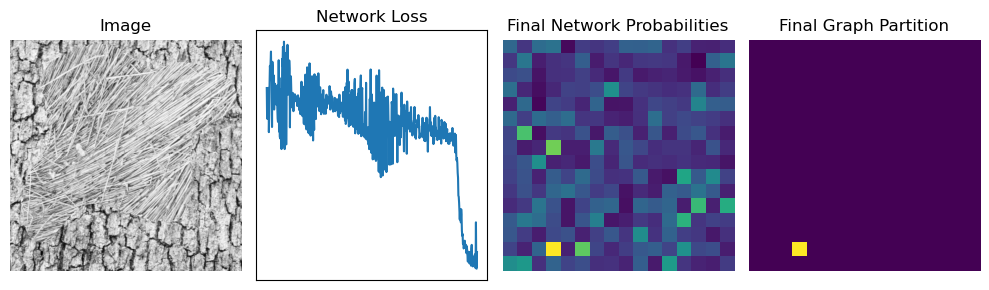

100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


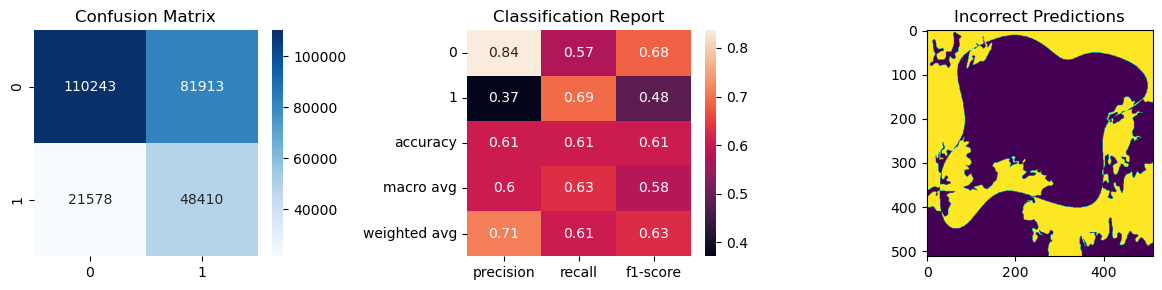

Average training time per iteration: 0.047712036768595374
Average graph cut time: 0.0008197112878163656


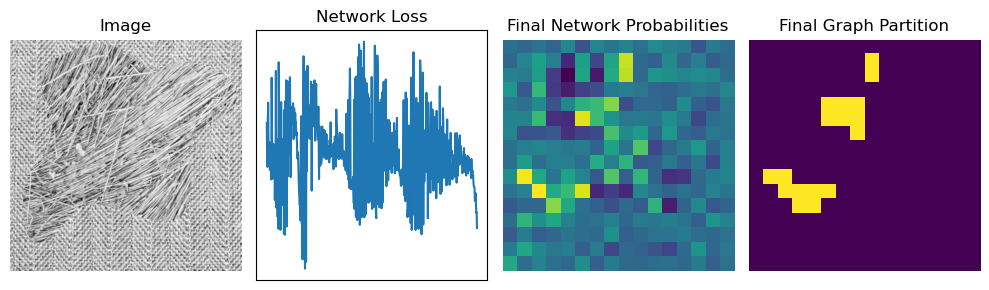

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


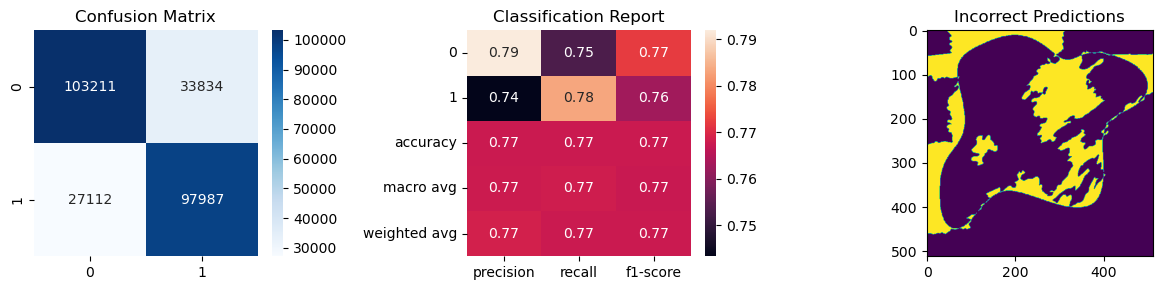

In [75]:
class Config:
    def __init__(self):
        self.d = 16
        self.n_filters = 32
        self.dropout = 0.2
        self.lambda_ = 0.2
        self.lr = 0.0001
        self.iterations = 600
        self.subset_size = 0.5
        self.prediction_stride = 4
        self.image_size = (512,512)
        self.noise = 0
        self.seed = 2

run_experiment(Config())

In [ ]:
# set environment variable
os.environ["WANDB_NOTEBOOK_NAME"] = "experiment.ipynb"
sweep_id = wandb.sweep(sweep_config, project="Graphically Guided Neural EM for Unsupervised Image Segmentation")
wandb.agent(sweep_id, function=run_experiment, count=1)